In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp

In [3]:
ticker=["AAPL","GOOGL","AMZN","MSFT"]
for t in ticker:
    data=yf.download(ticker,start='2020-1-1',auto_adjust=False)['Adj Close']

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


In [4]:
data.head()

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2020-01-02,72.468262,94.900497,67.965233,152.505707
2020-01-03,71.763741,93.748497,67.609688,150.606705
2020-01-06,72.335541,95.143997,69.411758,150.996048
2020-01-07,71.995331,95.343002,69.277687,149.619247
2020-01-08,73.153496,94.598503,69.770790,152.002457


In [5]:
returns=np.log(data/data.shift(1)).dropna()
returns

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2020-01-03,-0.009769,-0.012213,-0.005245,-0.012530
2020-01-06,0.007936,0.014776,0.026305,0.002582
2020-01-07,-0.004714,0.002089,-0.001933,-0.009160
2020-01-08,0.015959,-0.007839,0.007093,0.015803
2020-01-09,0.021018,0.004788,0.010443,0.012416
...,...,...,...,...
2025-12-01,0.015126,0.002826,-0.016660,-0.010769
2025-12-02,0.010856,0.002306,0.002917,0.006675
2025-12-03,-0.007154,-0.008740,0.012023,-0.025360


In [6]:
# MARKOWITZ MEAN-VARIANCE OPTIMIZATION

In [8]:
mu=returns.mean().values
cov=returns.cov().values
n=len(ticker)

w = cp.Variable(n)
risk = cp.quad_form(w, cov)
ret = mu @ w

prob = cp.Problem(cp.Minimize(risk), 
                  [cp.sum(w) == 1,
                   w >= 0])
prob.solve()

w_mv = w.value

print("Markowitz Weights:")
for t, wt in zip(ticker, w_mv):
    print(t, ":", round(wt, 3))


Markowitz Weights:
AAPL : 0.273
GOOGL : 0.098
AMZN : 0.222
MSFT : 0.407


In [ ]:
# CVaR PORTFOLIO OPTIMIZATION (95% CVaR)

In [10]:
alpha = 0.95
T = returns.shape[0]
R = returns.values

w_cvar = cp.Variable(n)
z = cp.Variable(T)
VaR = cp.Variable(1)

losses = -R @ w_cvar

prob_cvar = cp.Problem(cp.Minimize(VaR + (1/(1-alpha)/T) * cp.sum(z)),
                       [cp.sum(w_cvar) == 1,
                        w_cvar >= 0,
                        z >= 0,
                        z >= losses - VaR])
prob_cvar.solve()

w_cvar_opt = w_cvar.value

print("\nCVaR Optimal Weights:")
for t, wt in zip(ticker, w_cvar_opt):
    print(t, ":", round(wt, 3))


CVaR Optimal Weights:
AAPL : 0.205
GOOGL : 0.06
AMZN : 0.249
MSFT : 0.486


In [ ]:
# EFFICIENT FRONTIER PLOT

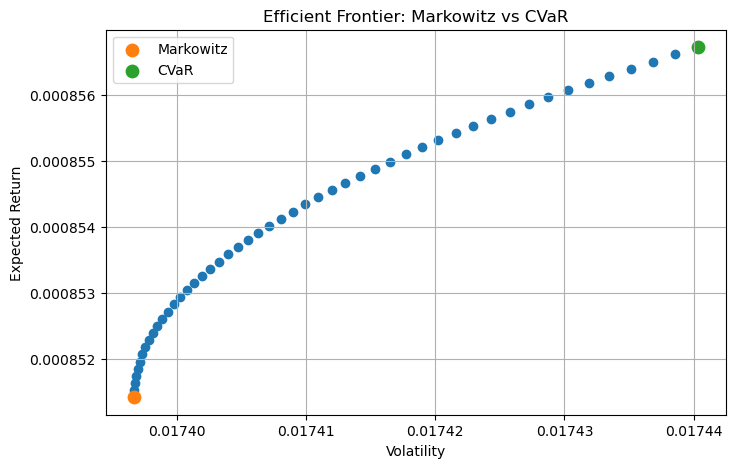

In [11]:
def portfolio_stats(w):
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    return vol, ret

vols, rets = [], []
for a in np.linspace(0, 1, 50):
    w_tmp = a * w_mv + (1-a) * w_cvar_opt
    vol, ret = portfolio_stats(w_tmp)
    vols.append(vol)
    rets.append(ret)

plt.figure(figsize=(8,5))
plt.scatter(vols, rets)
plt.scatter(*portfolio_stats(w_mv), s=80, label="Markowitz")
plt.scatter(*portfolio_stats(w_cvar_opt), s=80, label="CVaR")
plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier: Markowitz vs CVaR")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# WEIGHT BAR CHART

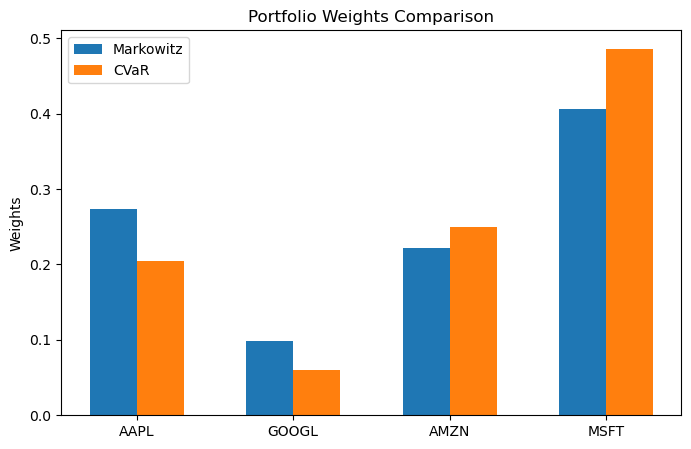

In [14]:
x = np.arange(n)
plt.figure(figsize=(8,5))
plt.bar(x-0.15, w_mv, width=0.3, label="Markowitz")
plt.bar(x+0.15, w_cvar_opt, width=0.3, label="CVaR")
plt.xticks(x, ticker)
plt.ylabel("Weights")
plt.title("Portfolio Weights Comparison")
plt.legend()
plt.show()